#Monthly Food Inflation Prediction in the Philippines

##Overview

In this study, the focus was on predicting the inflation rate in the Philippines using four machine learning models which are Random Forest Regressor, Support Vector Machine Regressor, XGBoost Regressor, and MLP Regressor (Neural Network). Each model was initially trained to establish baseline performance metrics, and different feature selection methods were employed based on the model type. The Random Forest Regressor and XGBoost Regressor utilized embedded methods, the Support Vector Machine Regressor applied Recursive Feature Elimination (RFE), and the MLP Regressor used filter methods. Extensive hyperparameter tuning was conducted using Grid Search to optimize model performance, and the models were evaluated using Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²).

The findings indicated that the XGBoost Regressor was the most effective model for predicting inflation rates in the Philippines, achieving the lowest MSE and MAE values and an R-squared value close to 1, reflecting strong predictive accuracy. Feature importance analysis revealed that the food price index, egg inflation, and onion inflation significantly impact inflation predictions. The SHAP analysis provided further clarity on these impacts: the food price index had a substantial and variable effect, as shown by its wide spread on the x-axis of the SHAP summary plot, while egg inflation and onion inflation had less variable impacts.

The SHAP dependence plots offered additional insights into how varying feature values affect inflation predictions. Specifically, the inflation rate tends to increase when the food price index is above 5, egg inflation is below 0, and onion inflation is above 0. Conversely, it decreases when the food price index is below 5, egg inflation is above 0, and onion inflation is below 0. Furthermore, the analysis suggested that a closing price of chicken meat above 150 and positive inflation prices for rice and cabbage also contribute to higher inflation rates, although these factors are less critical compared to the primary features.

In summary, the XGBoost Regressor is identified as the most accurate model for predicting inflation in the Philippines. The insights derived from feature importance and SHAP analysis provide a solid foundation for understanding the factors influencing inflation in the country and offer a basis for developing targeted policies to manage and mitigate inflation effectively.

# Section 1: Data Preparation

This section gives a brief overview of the datasets to be used and combined. It also gives an information on what the the features are present in the dataset.

Importing libraries and the dataset to be used

In [ ]:
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import r_regression
import seaborn as sns
from xgboost import XGBRegressor
import warnings
import joblib

warnings.filterwarnings('ignore')

In [ ]:
#Importing data
api_key = "1nmpTM6gW1HATAVMr7Yd3oAloaj3ycgrAVdS075cujd8"
xlsx = pd.ExcelFile(f"https://docs.google.com/spreadsheets/d/{api_key}/export?format=xlsx")

###Importing the first dataset

This data was obtained from: https://microdata.worldbank.org/index.php/catalog/4509/study-description

**Attributes**


*   Open - Monthly food price estimate (open)
*   High - Monthly food price estimate (high)
*   Low - Monthly food price estimate (low)
*   Close - Monthly food price estimate (close)
*   Inflation - Monthly estimate of food price inflation
*   ISO3 - Country code
*   date - Date of estimate (month/day/year)




In [ ]:
df1 = pd.read_excel(xlsx, sheet_name='s1')
df1 = df1.loc[df1['country']=='Philippines'].reset_index(drop=True)
df1

,Open,High,Low,Close,Inflation,country,ISO3,date
0,0.74,0.75,0.73,0.74,NaN,Philippines,PHL,2007-01-01
1,0.74,0.75,0.72,0.72,NaN,Philippines,PHL,2007-02-01
2,0.71,0.72,0.70,0.71,NaN,Philippines,PHL,2007-03-01
3,0.71,0.71,0.70,0.71,NaN,Philippines,PHL,2007-04-01
4,0.72,0.73,0.71,0.72,NaN,Philippines,PHL,2007-05-01
...,...,...,...,...,...,...,...,...
202,1.53,1.55,1.51,1.52,6.14,Philippines,PHL,2023-11-01
203,1.53,1.55,1.51,1.51,1.65,Philippines,PHL,2023-12-01
204,1.51,1.53,1.49,1.49,-3.53,Philippines,PHL,2024-01-01
205,1.47,1.53,1.45,1.53,3.02,Philippines,PHL,2024-02-01


###Importing second dataset

Additional information relating for these features can be found at:
https://microdata.worldbank.org/index.php/catalog/4509/data-api

In [ ]:
df2 = pd.read_excel(xlsx, sheet_name='s2')
df2

,ISO3,country,adm1_name,adm2_name,mkt_name,lat,lon,geo_id,DATES,year,...,l_yam,c_yam,inflation_yam,trust_yam,o_food_price_index,h_food_price_index,l_food_price_index,c_food_price_index,inflation_food_price_index,trust_food_price_index
0,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2007-01-01,2007,...,NaN,NaN,NaN,NaN,0.74,0.75,0.73,0.74,NaN,9.6
1,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2007-02-01,2007,...,NaN,NaN,NaN,NaN,0.74,0.75,0.72,0.72,NaN,9.6
2,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2007-03-01,2007,...,NaN,NaN,NaN,NaN,0.71,0.72,0.71,0.71,NaN,9.6
3,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2007-04-01,2007,...,NaN,NaN,NaN,NaN,0.71,0.72,0.70,0.72,NaN,9.6
4,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2007-05-01,2007,...,NaN,NaN,NaN,NaN,0.72,0.73,0.71,0.72,NaN,9.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2024-03-01,2024,...,NaN,NaN,NaN,NaN,1.44,1.45,1.42,1.42,-0.99,10.0
207,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2024-04-01,2024,...,NaN,NaN,NaN,NaN,1.41,1.43,1.39,1.39,0.60,10.0
208,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2024-05-01,2024,...,NaN,NaN,NaN,NaN,1.40,1.41,1.38,1.39,0.87,10.0
209,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2024-06-01,2024,...,NaN,NaN,NaN,NaN,1.40,1.42,1.38,1.41,1.03,10.0


###Merging the dataframe

In [ ]:
df2.rename(columns={'DATES':'date'}, inplace=True)

df2['date'] = pd.to_datetime(df2['date'])
df1['date'] = pd.to_datetime(df1['date'])

# Prevents duplicate columns in the dataframe
feats_to_include = set(df1.columns) - set(df2.columns)

#Include join key for merging
feats_to_include.add('date')

feats_to_include = list(feats_to_include)

In [ ]:
country_df = df2.merge(df1[feats_to_include], on='date',how='left', ).reset_index(drop=True)
country_df

,ISO3,country,adm1_name,adm2_name,mkt_name,lat,lon,geo_id,date,year,...,h_food_price_index,l_food_price_index,c_food_price_index,inflation_food_price_index,trust_food_price_index,Inflation,High,Close,Low,Open
0,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2007-01-01,2007,...,0.75,0.73,0.74,NaN,9.6,NaN,0.75,0.74,0.73,0.74
1,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2007-02-01,2007,...,0.75,0.72,0.72,NaN,9.6,NaN,0.75,0.72,0.72,0.74
2,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2007-03-01,2007,...,0.72,0.71,0.71,NaN,9.6,NaN,0.72,0.71,0.70,0.71
3,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2007-04-01,2007,...,0.72,0.70,0.72,NaN,9.6,NaN,0.71,0.71,0.70,0.71
4,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2007-05-01,2007,...,0.73,0.71,0.72,NaN,9.6,NaN,0.73,0.72,0.71,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2024-03-01,2024,...,1.45,1.42,1.42,-0.99,10.0,5.53,1.56,1.52,1.52,1.54
207,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2024-04-01,2024,...,1.43,1.39,1.39,0.60,10.0,NaN,NaN,NaN,NaN,NaN
208,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2024-05-01,2024,...,1.41,1.38,1.39,0.87,10.0,NaN,NaN,NaN,NaN,NaN
209,PHL,Philippines,Market Average,Market Average,Market Average,NaN,NaN,gid_phl_national_average,2024-06-01,2024,...,1.42,1.38,1.41,1.03,10.0,NaN,NaN,NaN,NaN,NaN


# Section 2: Data preprocessing

###Drop Redundant Columns

Since we analyzing food inlation in the Philippines, it is necessary to drop columns that doesn't add to the explaining inflation.

In [ ]:
feats_to_drop = set(country_df.columns) - set(country_df.select_dtypes(include=['number',np.datetime64]).columns)
feats_to_drop.add('month')
feats_to_drop.add('year')
feats_to_drop.add('start_dense_data')
feats_to_drop.add('last_survey_point')
feats_to_drop.add('lat')
feats_to_drop.add('lon')
feats_to_drop.add('data_coverage')
feats_to_drop.add('data_coverage_recent')
feats_to_drop.add('index_confidence_score')
feats_to_drop.add('spatially_interpolated')

feats_to_drop

{'ISO3',
 'adm1_name',
 'adm2_name',
 'components',
 'country',
 'currency',
 'data_coverage',
 'data_coverage_recent',
 'geo_id',
 'index_confidence_score',
 'last_survey_point',
 'lat',
 'lon',
 'mkt_name',
 'month',
 'spatially_interpolated',
 'start_dense_data',
 'year'}

We are predicting inflation using Market average value only

In [ ]:
print(country_df['adm1_name'].unique())
print(country_df['adm2_name'].unique())
print(country_df['mkt_name'].unique())

['Market Average']
['Market Average']
['Market Average']


Dropping the selected columns

In [ ]:
country_df = country_df.drop(columns= list(feats_to_drop))

Displaying

In [ ]:
country_df.head()

,date,apples,bananas,beans,bread,bulgur,cabbage,carrots,cassava,cassava_flour,...,h_food_price_index,l_food_price_index,c_food_price_index,inflation_food_price_index,trust_food_price_index,Inflation,High,Close,Low,Open
0,2007-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.75,0.73,0.74,NaN,9.6,NaN,0.75,0.74,0.73,0.74
1,2007-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.75,0.72,0.72,NaN,9.6,NaN,0.75,0.72,0.72,0.74
2,2007-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.72,0.71,0.71,NaN,9.6,NaN,0.72,0.71,0.70,0.71
3,2007-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.72,0.70,0.72,NaN,9.6,NaN,0.71,0.71,0.70,0.71
4,2007-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.73,0.71,0.72,NaN,9.6,NaN,0.73,0.72,0.71,0.72


###Converting column names to lowercase

Create a key-value pair that contains the lowercase string version of the feature name for a convenient referencing

In [ ]:
name_dict = dict()

for col in country_df.columns:
  name_dict[col] = col.lower()

country_df.rename(columns=name_dict,inplace=True)

###Handling Missing values

Dropping columns via thresholding. Keep only features that have only at most 10% missing values based on the size of the dataframe.

In [ ]:
# Get the percentage of missing values for each columns
null_p = country_df.isna().sum()/ country_df.shape[0]

#Keep only the columns that are below the threshold value
country_df = country_df[null_p[null_p <= 0.10].index]

print(f'Number of columns kept: {len(country_df.columns)}')

Number of columns kept: 84


Fill the misisng missing values using KNN Imputer

In [ ]:
country_df.isna().sum()

date          0
o_beans       0
h_beans       0
l_beans       0
c_beans       0
             ..
inflation    16
high          4
close         4
low           4
open          4
Length: 84, dtype: int64

In [ ]:
# Impute the value by getting the average of the 5 nearest neighbor
imputer = KNNImputer(n_neighbors=5)

# Temporarily remove date datatype from the dataframe before using the imputer to prevent datatype error when running KNN imputer
date_data = country_df['date']
column_order = country_df.columns
df_temp = country_df.drop('date',axis=1)

# Run KNN imputer using the temp dataframe
country_df = pd.DataFrame(imputer.fit_transform(df_temp),columns = df_temp.columns)

In [ ]:
# Add back the data feature to the dataframe
country_df['date'] = date_data

# Reorganize column
country_df = country_df[column_order]

# Display result
country_df

,date,o_beans,h_beans,l_beans,c_beans,inflation_beans,trust_beans,o_cabbage,h_cabbage,l_cabbage,...,h_food_price_index,l_food_price_index,c_food_price_index,inflation_food_price_index,trust_food_price_index,inflation,high,close,low,open
0,2007-01-01,77.74,78.68,76.86,77.79,-0.692,8.6,32.06,36.30,28.88,...,0.75,0.73,0.74,3.102,9.6,4.086,0.750,0.740,0.730,0.740
1,2007-02-01,77.82,78.73,76.62,76.79,-1.048,8.6,33.25,37.04,29.46,...,0.75,0.72,0.72,2.810,9.6,3.758,0.750,0.720,0.720,0.740
2,2007-03-01,76.79,77.72,75.80,76.27,-1.048,8.6,31.76,35.35,28.17,...,0.72,0.71,0.71,2.810,9.6,3.758,0.720,0.710,0.700,0.710
3,2007-04-01,76.36,77.24,75.49,76.17,-1.048,8.6,29.89,33.22,26.57,...,0.72,0.70,0.72,2.810,9.6,3.758,0.710,0.710,0.700,0.710
4,2007-05-01,76.29,77.13,75.45,76.38,-1.048,8.6,31.22,34.52,27.91,...,0.73,0.71,0.72,2.810,9.6,3.758,0.730,0.720,0.710,0.720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,2024-03-01,104.21,105.80,102.02,103.00,-0.770,9.5,81.74,90.09,72.97,...,1.45,1.42,1.42,-0.990,10.0,5.530,1.560,1.520,1.520,1.540
207,2024-04-01,103.04,104.78,101.14,102.37,-1.290,9.5,84.96,94.07,75.88,...,1.43,1.39,1.39,0.600,10.0,7.220,1.404,1.392,1.362,1.382
208,2024-05-01,102.46,104.09,100.78,102.28,-1.290,9.5,88.79,98.75,79.75,...,1.41,1.38,1.39,0.870,10.0,7.220,1.404,1.392,1.362,1.382
209,2024-06-01,102.47,104.13,100.85,102.67,-0.710,9.5,96.07,105.97,85.94,...,1.42,1.38,1.41,1.030,10.0,7.220,1.404,1.392,1.362,1.382


Check if all missing values have been filled

In [ ]:
country_df.isna().sum().sum()

0

###Handling Duplicate values

Since there are no duplicated values, no operations shall be performed

In [ ]:
country_df.duplicated().sum()

0

In [ ]:
country_df

,date,o_beans,h_beans,l_beans,c_beans,inflation_beans,trust_beans,o_cabbage,h_cabbage,l_cabbage,...,h_food_price_index,l_food_price_index,c_food_price_index,inflation_food_price_index,trust_food_price_index,inflation,high,close,low,open
0,2007-01-01,77.74,78.68,76.86,77.79,-0.692,8.6,32.06,36.30,28.88,...,0.75,0.73,0.74,3.102,9.6,4.086,0.750,0.740,0.730,0.740
1,2007-02-01,77.82,78.73,76.62,76.79,-1.048,8.6,33.25,37.04,29.46,...,0.75,0.72,0.72,2.810,9.6,3.758,0.750,0.720,0.720,0.740
2,2007-03-01,76.79,77.72,75.80,76.27,-1.048,8.6,31.76,35.35,28.17,...,0.72,0.71,0.71,2.810,9.6,3.758,0.720,0.710,0.700,0.710
3,2007-04-01,76.36,77.24,75.49,76.17,-1.048,8.6,29.89,33.22,26.57,...,0.72,0.70,0.72,2.810,9.6,3.758,0.710,0.710,0.700,0.710
4,2007-05-01,76.29,77.13,75.45,76.38,-1.048,8.6,31.22,34.52,27.91,...,0.73,0.71,0.72,2.810,9.6,3.758,0.730,0.720,0.710,0.720
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,2024-03-01,104.21,105.80,102.02,103.00,-0.770,9.5,81.74,90.09,72.97,...,1.45,1.42,1.42,-0.990,10.0,5.530,1.560,1.520,1.520,1.540
207,2024-04-01,103.04,104.78,101.14,102.37,-1.290,9.5,84.96,94.07,75.88,...,1.43,1.39,1.39,0.600,10.0,7.220,1.404,1.392,1.362,1.382
208,2024-05-01,102.46,104.09,100.78,102.28,-1.290,9.5,88.79,98.75,79.75,...,1.41,1.38,1.39,0.870,10.0,7.220,1.404,1.392,1.362,1.382
209,2024-06-01,102.47,104.13,100.85,102.67,-0.710,9.5,96.07,105.97,85.94,...,1.42,1.38,1.41,1.030,10.0,7.220,1.404,1.392,1.362,1.382


# Section 3: Model Development

In this section, each model will be developed in the following steps:
1. Initial Training
2. Feature Selection
3. Hyperparameter Tuning with 5-fold Cross Validation
4. Model Evaluation

The models to be trained are the following:
- Random Forest Regressor
- Support Vector Machine Regressor
- XGBoost Regressor
- MLP Regressor (Neural Network)

The metrics by which the regressor models are evaluated are:
- MSE
- RMSE
- MAE
- R2

NOTE: IN CASE YOU WANT TO AVOID TRAINING THE WHOLE MODEL FROM SCRATCH, YOU MAY IMPORT THE BEST MODEL BY RUNNING THE CELL BELOW

In [ ]:
import pickle

In [ ]:
# CHANGE PATH WHEN FILES HAVE BEEN MADE

with open('best_random_forest_model.pkl','rb') as f:
    RF_best = pickle.load(f)

with open('best_xgb_model.pkl','rb') as f:
    XG_best = pickle.load(f)

with open('best_svm_model.pkl','rb') as f:
    unpickled_array = pickle.load(f)

with open('best_mlp_model.pkl','rb') as f:
    MLP_best = pickle.load(f)


## Setting up Global Variables

In [ ]:
# We designated the random seed for replicability, the number of processors each algorithm uses, and the number of folds in the cross validation setup
seed = 42
jobs = -1 # Use all processors
folds = 5 # 5-fold cross validation
n_iter = 10 # 10 iterations for finding importance
feature_select_threshold = 0.001  # Threshold for selecting feature importance

In [ ]:
# We create the base X and y sets of features that have not been filtered
X = country_df.drop(['date','inflation'],axis=1)
y = country_df['inflation']

# Creating training data and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

In [ ]:
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
import joblib # For saving the best model

In [ ]:
# Define scorers for Grid Search
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

## Random Forest

### Initial Training

In [ ]:
# Initialize RF importances
RF_importances = np.zeros(X_train.shape[1])

# Train model n_iter time at different seeds
for i in range(n_iter):
    rfr_init = RandomForestRegressor(random_state=i)  # Change seed
    rfr_init.fit(X_train, y_train)
    RF_importances += rfr_init.feature_importances_  # Accumulate importances

# Compute average feature importances
RF_importances /= n_iter

###Feature selection using Embedded Methods

Calculate importance using gini score

In [ ]:
# Create a dataframe
RF_importances_df = pd.DataFrame({'feature': X.columns, 'importance': RF_importances})
RF_importances_df = RF_importances_df.sort_values('importance', ascending=True).reset_index(drop=True)

RF_importances_df

,feature,importance
0,trust_meat_beef_chops,0.000049
1,trust_meat_pork,0.000064
2,trust_meat_chicken_whole,0.000074
3,trust_potatoes,0.000087
4,h_food_price_index,0.000090
...,...,...
77,inflation_meat_pork,0.002304
78,inflation_onions,0.002598
79,inflation_rice,0.003903
80,inflation_eggs,0.006628


Plot the top 10 important features

<BarContainer object of 10 artists>

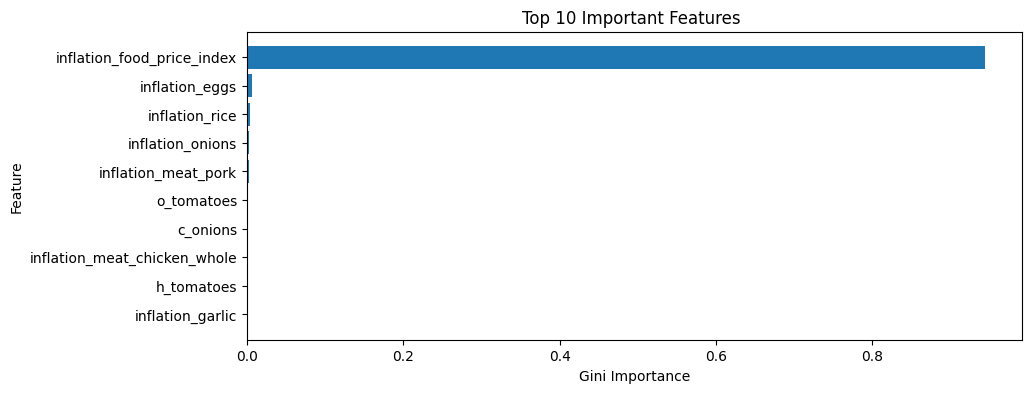

In [ ]:
# Plot the feature importances
plt.figure(figsize=(10,4))
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Top 10 Important Features ')
plt.barh(RF_importances_df['feature'].tail(10), RF_importances_df['importance'].tail(10))

Keeping only the features whose gini importance is greater than 0.001

In [ ]:
# Select the features based on the threshold
RF_features = RF_importances_df[RF_importances_df['importance'] > feature_select_threshold]['feature']
X_RF = X_train[RF_features]
X_RF.columns

Index(['inflation_potatoes', 'inflation_carrots', 'o_onions', 'l_cabbage',
       'h_onions', 'inflation_meat_beef_chops', 'inflation_garlic',
       'h_tomatoes', 'inflation_meat_chicken_whole', 'c_onions', 'o_tomatoes',
       'inflation_meat_pork', 'inflation_onions', 'inflation_rice',
       'inflation_eggs', 'inflation_food_price_index'],
      dtype='object')

### Hyperparameter Tuning

In [ ]:
# Specify RF hyperparameter grid
RF_params = {
    'n_estimators': [25, 50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [ ]:
# Train the model with cross validation
RF = RandomForestRegressor(random_state=seed)
RF_grid_search = GridSearchCV(estimator=RF, param_grid=RF_params,
                           cv=folds, scoring={'MSE': mse_scorer, 'MAE': mae_scorer},
                           refit='MSE', return_train_score=True, n_jobs=-1)
RF_grid_search.fit(X_RF, y_train)

# Print the best results
print("Best parameters found: ", RF_grid_search.best_params_)
print("Best MSE score: ", -RF_grid_search.best_score_)

Best parameters found:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best MSE score:  1.212304151289793


In [ ]:
# Save the CV results
RF_cv_results = pd.DataFrame(RF_grid_search.cv_results_)
RF_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,...,mean_test_MAE,std_test_MAE,rank_test_MAE,split0_train_MAE,split1_train_MAE,split2_train_MAE,split3_train_MAE,split4_train_MAE,mean_train_MAE,std_train_MAE
0,0.352870,0.103414,0.030857,0.017445,True,None,1,2,25,"{'bootstrap': True, 'max_depth': None, 'min_sa...",...,-0.753644,0.158720,65,-0.336706,-0.294138,-0.316847,-0.269706,-0.315918,-0.306663,0.022868
1,0.563229,0.022828,0.048099,0.026949,True,None,1,2,50,"{'bootstrap': True, 'max_depth': None, 'min_sa...",...,-0.715762,0.171355,17,-0.311818,-0.274005,-0.304062,-0.272957,-0.291767,-0.290922,0.015614
2,1.208352,0.229997,0.038996,0.016848,True,None,1,2,100,"{'bootstrap': True, 'max_depth': None, 'min_sa...",...,-0.708064,0.180543,9,-0.297334,-0.271016,-0.285311,-0.250004,-0.282695,-0.277272,0.015995
3,2.125939,0.510511,0.075858,0.022896,True,None,1,2,200,"{'bootstrap': True, 'max_depth': None, 'min_sa...",...,-0.700029,0.194174,4,-0.299578,-0.268408,-0.282468,-0.247540,-0.276251,-0.274849,0.017081
4,3.197485,0.263606,0.075319,0.027541,True,None,1,2,300,"{'bootstrap': True, 'max_depth': None, 'min_sa...",...,-0.697179,0.202122,1,-0.297071,-0.267539,-0.276207,-0.243028,-0.276104,-0.271990,0.017449


###Model Evaluation

In [ ]:
# Show the best RF model
RF_best = RF_grid_search.best_estimator_

y_pred = RF_best.predict(X_test[X_RF.columns])

# Compute for the metrics
RF_mse = mean_squared_error(y_test, y_pred)
RF_mae = mean_absolute_error(y_test, y_pred)
RF_r2 = r2_score(y_pred,y_test)
RF_rmse = np.sqrt(RF_mse)

print(f'MSE After optimizing the model: {RF_mse}')
print(f'MAE After optimizing the model: {RF_mae}')
print(f'R-squared After optimizing the model: {RF_r2}')
print(f'RMSE After optimizing the model: {RF_rmse}')

MSE After optimizing the model: 0.9508277422812497
MAE After optimizing the model: 0.6735496875000001
R-squared After optimizing the model: 0.9667333085566127
RMSE After optimizing the model: 0.9751039648577221


In [ ]:
# Save the best RF model using joblib
joblib.dump(RF_best, 'best_random_forest_model.pkl')

['best_random_forest_model.pkl']

## SVM Regressor

### Initial Training

In [ ]:
#Define and Fit the Pipeline
SVR_selection_pipeline = make_pipeline(
    StandardScaler(),
    RFECV(
        SVR(kernel='linear'),
        min_features_to_select=5,
        step=1,
        cv=10,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
)

# Fit the dataset to the pipeline
SVR_selection_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('rfecv',
                 RFECV(cv=10, estimator=SVR(kernel='linear'),
                       min_features_to_select=5, n_jobs=-1,
                       scoring='neg_mean_squared_error'))])

### Feature Selection for SVM Regression using Recursive Feature Elimination

In [ ]:
# Extract Selected Features
SVR_selector = SVR_selection_pipeline.named_steps['rfecv']
SVR_features = X.columns[SVR_selector.support_]

X_SVR = X_train[SVR_features]

The selected features are

In [ ]:
X_SVR.columns

Index(['l_beans', 'o_carrots', 'h_carrots', 'l_carrots', 'inflation_carrots',
       'h_eggs', 'l_eggs', 'inflation_eggs', 'trust_eggs', 'trust_garlic',
       'o_meat_beef_chops', 'l_meat_beef_chops', 'inflation_meat_beef_chops',
       'trust_meat_beef_chops', 'o_meat_pork', 'l_meat_pork',
       'inflation_meat_pork', 'trust_meat_pork', 'h_onions', 'l_onions',
       'c_onions', 'inflation_onions', 'trust_onions', 'inflation_potatoes',
       'inflation_rice', 'inflation_tomatoes', 'h_food_price_index',
       'c_food_price_index', 'inflation_food_price_index', 'high', 'close',
       'low', 'open'],
      dtype='object')

Perform sa sample training to visualize feature importance using SVM Regressor

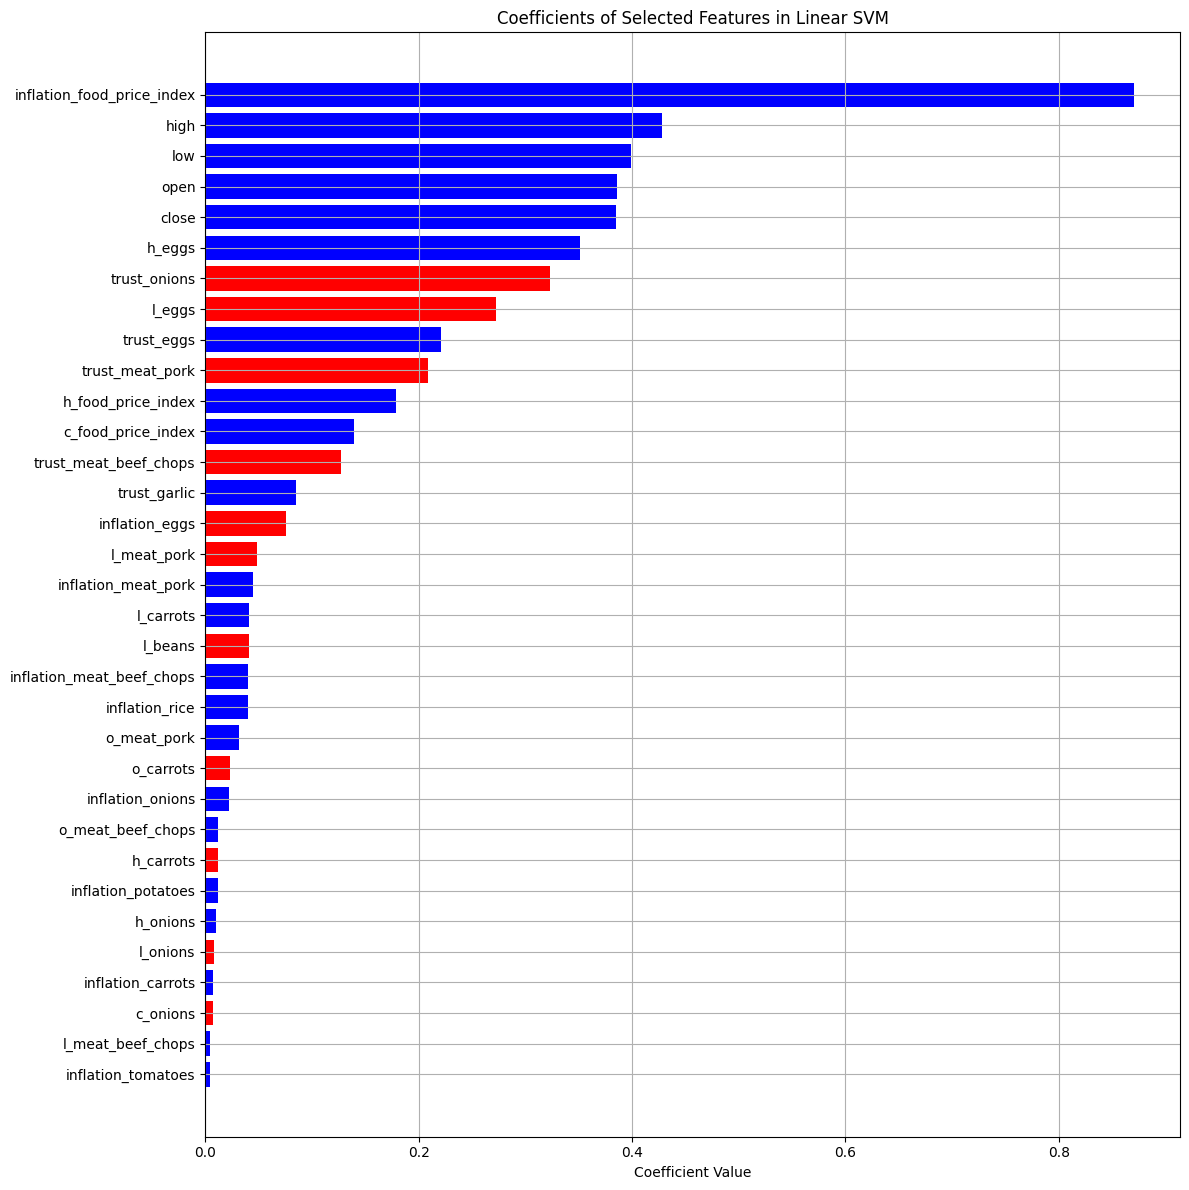

In [ ]:
# Sample training to visualize weights
svm_sample = SVR(kernel='linear')
svm_sample.fit(X_SVR, y_train)

# Obtain Coefficients
coefficients = svm_sample.coef_.flatten()

# Prepare Data for Plotting
SVR_coeff_df = pd.DataFrame({
    'Feature': SVR_features,
    'Coefficient': coefficients
})

# Sort DataFrame by the absolute value of coefficients in descending order
SVR_coeff_df['Absolute Coefficient'] = SVR_coeff_df['Coefficient'].abs()
SVR_coeff_df = SVR_coeff_df.sort_values(by='Absolute Coefficient', ascending=True)

# Determine Colors Based on Coefficient Sign
colors = SVR_coeff_df['Coefficient'].apply(lambda x: 'blue' if x > 0 else 'red')

# Plotting
plt.figure(figsize=(12, 12))  # Increase figure size to accommodate more features
plt.barh(SVR_coeff_df['Feature'], SVR_coeff_df['Absolute Coefficient'], color=colors)
plt.xlabel('Coefficient Value')
plt.title('Coefficients of Selected Features in Linear SVM')
plt.grid(True)

# Add padding for better layout
plt.tight_layout()

plt.show()

### Hyperparameter Tuning

In [ ]:
SVR_params = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1, 10],
    'kernel': ['rbf']
}

In [ ]:
SVM = SVR()
SVM_grid_search = GridSearchCV(estimator=SVM, param_grid=SVR_params,
                           cv=folds, scoring={'MSE': mse_scorer, 'MAE': mae_scorer},
                           refit='MSE', return_train_score=True, n_jobs=jobs)
SVM_grid_search.fit(X_SVR, y_train)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 1, 10],
                         'kernel': ['rbf']},
             refit='MSE', return_train_score=True,
             scoring={'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
                      'MSE': make_scorer(mean_squared_error, greater_is_better=False)})

Displaying the best parameters for SVR

In [ ]:
print("Best parameters found: ", SVM_grid_search.best_params_)
print("Best MSE score: ", -SVM_grid_search.best_score_)

Best parameters found:  {'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}
Best MSE score:  1.1899392002121885


Displaying the Grid Search Result

In [ ]:
SVM_cv_results = pd.DataFrame(SVM_grid_search.cv_results_)
SVM_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_epsilon,param_kernel,params,split0_test_MSE,split1_test_MSE,...,mean_test_MAE,std_test_MAE,rank_test_MAE,split0_train_MAE,split1_train_MAE,split2_train_MAE,split3_train_MAE,split4_train_MAE,mean_train_MAE,std_train_MAE
0,0.007415,0.002496,0.005688,0.002106,0.1,0.01,rbf,"{'C': 0.1, 'epsilon': 0.01, 'kernel': 'rbf'}",-17.146227,-33.903956,...,-3.961283,0.384551,14,-4.059368,-3.814758,-3.869056,-3.876079,-3.953910,-3.914634,0.084888
1,0.005651,0.000331,0.004421,0.000173,0.1,0.1,rbf,"{'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}",-17.135617,-33.892298,...,-3.960858,0.381730,13,-4.060442,-3.814521,-3.860543,-3.876628,-3.952515,-3.912930,0.086108
2,0.006093,0.001413,0.004367,0.000221,0.1,1,rbf,"{'C': 0.1, 'epsilon': 1, 'kernel': 'rbf'}",-17.340134,-33.982691,...,-4.028967,0.390444,15,-4.105342,-3.826972,-3.912089,-3.876989,-3.993008,-3.942880,0.097602
3,0.004390,0.000269,0.004207,0.000339,0.1,10,rbf,"{'C': 0.1, 'epsilon': 10, 'kernel': 'rbf'}",-22.227235,-39.034848,...,-4.482680,0.295110,16,-4.591696,-4.284109,-4.061311,-4.094150,-4.704884,-4.347230,0.259794
4,0.005973,0.000405,0.004753,0.000209,1,0.01,rbf,"{'C': 1, 'epsilon': 0.01, 'kernel': 'rbf'}",-10.174562,-24.239369,...,-3.152251,0.341315,8,-3.109311,-2.862957,-3.120555,-3.016273,-3.020742,-3.025968,0.092289


###Model Evaluation

In [ ]:
SVM_best_model = SVM_grid_search.best_estimator_
y_pred = SVM_best_model.predict(X_test[X_SVR.columns])

svm_mse = mean_squared_error(y_test, y_pred)
svm_mae = mean_absolute_error(y_test, y_pred)
svm_r2 = r2_score(y_pred,y_test)
svm_rmse = np.sqrt(svm_mse)

print(f'MSE After optimizing the model: {svm_mse}')
print(f'MAE After optimizing the model: {svm_mae}')
print(f'R-squared After optimizing the model: {svm_r2}')
print(f'RMSE After optimizing the model: {svm_rmse}')

MSE After optimizing the model: 1.9206143690355604
MAE After optimizing the model: 0.972176207135377
R-squared After optimizing the model: 0.9362370854541615
RMSE After optimizing the model: 1.385862319653565


In [ ]:
# Save the best model using joblib
joblib.dump(SVM_best_model, 'best_svm_model.pkl')

['best_svm_model.pkl']

## XGBoost Regressor

### Initial Training

In [ ]:
# initial training code here

model = XGBRegressor()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)


MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)

print(f'MSE: {MSE}')
print(f' MAE: {MAE}')

Final Model MSE: 0.9941673017256947
Final Model MAE: 0.7451486667939462


### Feature Selection using Embedded Method

Select the best features for the model using the top via thresholding based on the computed feature importance score

In [ ]:
# Get the score of each feature. Which is computed by the average gain across all splits the feature is used in.
f_importance = model.get_booster().get_score(importance_type='gain')

# Create a dataframe that stores the gain score of each features
importance_df = pd.DataFrame.from_dict(data=f_importance,
                                       orient='index')

# Get only the features that have a gain score of at least 1
XG_best_feats = importance_df[importance_df[0] >= 1.0]

# Display the top 10 features
XG_best_feats.head(10)

,0
inflation_eggs,1.210223
o_garlic,1.118683
o_meat_beef_chops,4.796124
trust_onions,1.338610
inflation_rice,1.041081
inflation_food_price_index,59.603844


Plotting the feature importance

<Axes: title={'center': 'Top Features for XGBoost Regressor'}, xlabel='gain', ylabel='feature_name'>

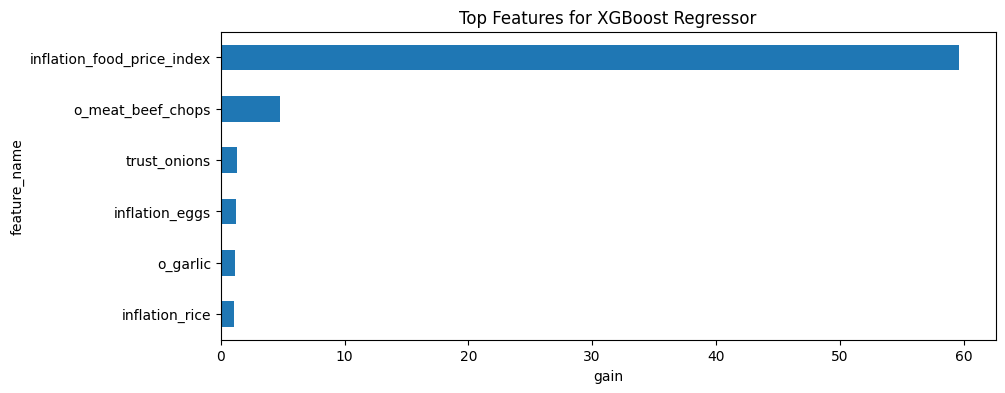

In [ ]:
XG_best_feats.sort_values(by=0, ascending=True, inplace=True)

XG_best_feats.plot.barh(legend=False, figsize=(10,4),
                        title='Top Features for XGBoost Regressor',
                        ylabel='feature_name',
                        xlabel='gain')

### Hyperparameter Tuning

In [ ]:
# hyperparameter tuning code here
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'min_child_weight': [1, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=10,n_jobs=-1)
grid_search.fit(X_train[XG_best_feats.index], y_train)

# Print the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best MSE score: ", -grid_search.best_score_)

Best parameters found:  {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
Best MSE score:  0.7777712317454797


###Model Evaluation

In [ ]:
best_xgb = grid_search.best_estimator_
best_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred = best_xgb.predict(X_test[XG_best_feats.index])

xgb_mse = mean_squared_error(y_test, y_pred)
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_r2 = r2_score(y_pred,y_test)
xgb_rmse = np.sqrt(xgb_mse)

print(f'MSE After optimizing the model: {xgb_mse}')
print(f'MAE After optimizing the model: {xgb_mae}')
print(f'R-squared After optimizing the model: {xgb_r2}')
print(f'RMSE After optimizing the model: {xgb_rmse}')

MSE After optimizing the model: 0.4577327647259736
MAE After optimizing the model: 0.4876886584835593
R-squared After optimizing the model: 0.9843465227622367
RMSE After optimizing the model: 0.6765595056800057


In [ ]:
joblib.dump(best_xgb, 'best_xgb_model.pkl')

['best_xgb_model.pkl']

## MLP Regressor (Neural Network)

### Initial Training

In [ ]:
# feature selection code here
mlp_r = MLPRegressor(random_state=seed)
mlp_r.fit(X_train, y_train)

y_pred = mlp_r.predict(X_test)

MSE = mean_squared_error(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)

In [ ]:
print(f' MSE: {MSE}')
print(f' MAE: {MAE}')

 MSE: 9.68792728003013
 MAE: 2.2327554646828602


### Alternative Feature Selection using Filter Method

Possible solution for feature reduction of MLP Regressor using Pearson's correlation since both input and the output value are numerical.

In [ ]:
thresh = 0.55
# X_MLP = X[r_regression(X, y) >= thresh]
MLP_X = X_train[X.columns[r_regression(X_test,y_test)>= thresh]]
MLP_X.columns

Index(['c_beans', 'inflation_beans', 'o_cabbage', 'h_cabbage', 'l_cabbage',
       'c_cabbage', 'o_carrots', 'h_carrots', 'l_carrots', 'c_carrots',
       'inflation_carrots', 'h_onions', 'l_onions', 'c_onions', 'o_tomatoes',
       'h_tomatoes', 'l_tomatoes', 'c_tomatoes', 'inflation_tomatoes',
       'inflation_food_price_index'],
      dtype='object')

### Hyperparameter Tuning

In [ ]:
MLP_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.01, 1, 10],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

MLP = MLPRegressor(random_state=seed)
MLP_grid_search = GridSearchCV(estimator=MLP, param_grid=MLP_params,
                           cv=folds, scoring={'MSE': mse_scorer, 'MAE': mae_scorer},
                           refit='MSE', return_train_score=True, n_jobs=jobs)
MLP_grid_search.fit(MLP_X,y_train)

print("Best parameters found: ", MLP_grid_search.best_params_)
print("Best MSE score: ", -MLP_grid_search.best_score_)

Best parameters found:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'solver': 'lbfgs'}
Best MSE score:  1.1689151502961155


Displaying grid search result

In [ ]:
MLP_cv_results = pd.DataFrame(MLP_grid_search.cv_results_)
MLP_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_activation,param_alpha,param_hidden_layer_sizes,param_learning_rate,param_learning_rate_init,param_solver,...,mean_test_MAE,std_test_MAE,rank_test_MAE,split0_train_MAE,split1_train_MAE,split2_train_MAE,split3_train_MAE,split4_train_MAE,mean_train_MAE,std_train_MAE
0,0.210774,0.012915,0.008297,0.003896,relu,0.0001,"(50,)",constant,0.001,lbfgs,...,-8.638538e-01,1.077075e-01,46,-0.628325,-0.557350,-0.507106,-4.819319e-01,-0.588050,-5.525526e-01,5.306069e-02
1,0.016095,0.001623,0.005913,0.000531,relu,0.0001,"(50,)",constant,0.001,sgd,...,-9.761862e+01,1.706614e+02,694,-13.555599,-14.254222,-10.083413,-4.417916e+02,-14.275764,-9.879211e+01,1.715067e+02
2,0.193511,0.018591,0.006883,0.002044,relu,0.0001,"(50,)",constant,0.001,adam,...,-1.812901e+00,1.488880e-01,226,-1.474685,-1.364570,-1.322029,-1.386425e+00,-1.430419,-1.395626e+00,5.277612e-02
3,0.208001,0.012966,0.005482,0.000590,relu,0.0001,"(50,)",constant,0.01,lbfgs,...,-8.638538e-01,1.077075e-01,46,-0.628325,-0.557350,-0.507106,-4.819319e-01,-0.588050,-5.525526e-01,5.306069e-02
4,0.014294,0.001675,0.005680,0.000847,relu,0.0001,"(50,)",constant,0.01,sgd,...,-1.026847e+09,2.053676e+09,736,-12111.379557,-7688.209172,-9145.976328,-5.134199e+09,-9194.081975,-1.026847e+09,2.053676e+09


###Model Evaluation

In [ ]:
MLP_best_model = MLP_grid_search.best_estimator_
y_pred = MLP_best_model.predict(X_test[MLP_X.columns])

mlp_mse = mean_squared_error(y_test, y_pred)
mlp_mae = mean_absolute_error(y_test, y_pred)
mlp_r2 = r2_score(y_pred,y_test)
mlp_rmse = np.sqrt(mlp_mse)

print(f'MSE After optimizing the model: {mlp_mse}')
print(f'MAE After optimizing the model: {mlp_mae}')
print(f'R-squared After optimizing the model: {mlp_r2}')
print(f'RMSE After optimizing the model: {mlp_rmse}')

MSE After optimizing the model: 1.601597258785171
MAE After optimizing the model: 0.982601653517537
R-squared After optimizing the model: 0.9452470693417252
RMSE After optimizing the model: 1.2655422785451187


In [ ]:
# Save the best model using joblib
joblib.dump(MLP_best_model, 'best_mlp_model.pkl')

['best_mlp_model.pkl']

# Section 4: Model Comparison and Results

During the model development phase, four models were used: Random Forest Regressor, Support Vector Machine Regressor, XGBoost Regressor, and MLP Regressor (Neural Network). Each model was initially trained using the provided dataset to establish baseline performance metrics. Following this, feature selection was performed using different methods tailored to each model: the Random Forest Regressor and XGBoost Regressor utilized embedded methods, the Support Vector Machine Regressor applied Recursive Feature Elimination (RFE), and the MLP Regressor employed filter methods to identify significant features.

After feature selection, extensive hyperparameter tuning was conducted to optimize the performance of each model, using techniques such as Grid Search. The models were then evaluated based on four key metrics: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²).

The table below provides a summary of the model evaluation metrics after optimizing the model.

In [ ]:
MSE = [RF_mse,svm_mse,xgb_mse,mlp_mse]
RMSE = [RF_rmse,svm_rmse,xgb_rmse,mlp_rmse]
MAE = [RF_mae,svm_mae,xgb_mae,mlp_mae]
R2 = [RF_r2,svm_r2,xgb_r2,mlp_r2]
Models = pd.DataFrame({
    'Model': ["Random Forest Regressor","Support Vector Machine Regressor","XGBoost Regressor","MLP Regressor (Neural Network)"],
    'MSE': MSE,
    'RMSE':RMSE,
    'MAE': MAE,
    'R-squared':R2})
Models

,Model,MSE,RMSE,MAE,R-squared
0,Random Forest Regressor,0.950828,0.975104,0.673550,0.966733
1,Support Vector Machine Regressor,1.920614,1.385862,0.972176,0.936237
2,XGBoost Regressor,0.457733,0.676560,0.487689,0.984347
3,MLP Regressor (Neural Network),1.601597,1.265542,0.982602,0.945247


Based on the table, the XGBoost Regressor emerged as the best-performing model, achieving the lowest values for MSE and MAE, and an R-squared value close to 1, indicating strong predictive performance and accuracy. These results demonstrate that the XGBoost Regressor has the highest predictive accuracy and reliability, making it the best model for this dataset.

# Section 5: Model Explainability

## Model Explainability using SHAP

In [ ]:
# Install SHAP if not already installed
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.2 MB/s eta 0:00:00


In [ ]:
# Import the package
import shap
shap.initjs()

In [ ]:
XG_best.fit(X_train,y_train)

# Calculate the SHAP Value
explainer = shap.TreeExplainer(XG_best)
shap_values = explainer.shap_values(X_train)

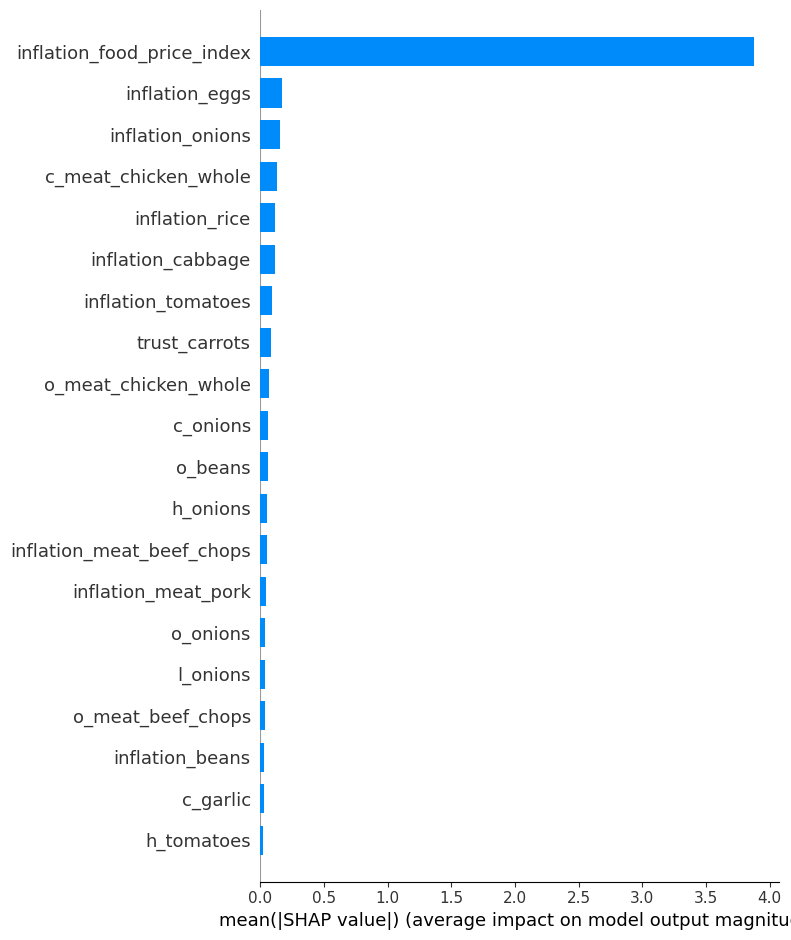

In [ ]:
# SHAP Feature importance
shap.summary_plot(shap_values, X_train, plot_type="bar")

As shown from the feature importance that food price index, egg infaltion, and onion inflation has significant influence on the prediction of inflation rate.

The SHAP summary plot shows which features are most significant for predicting inflation.

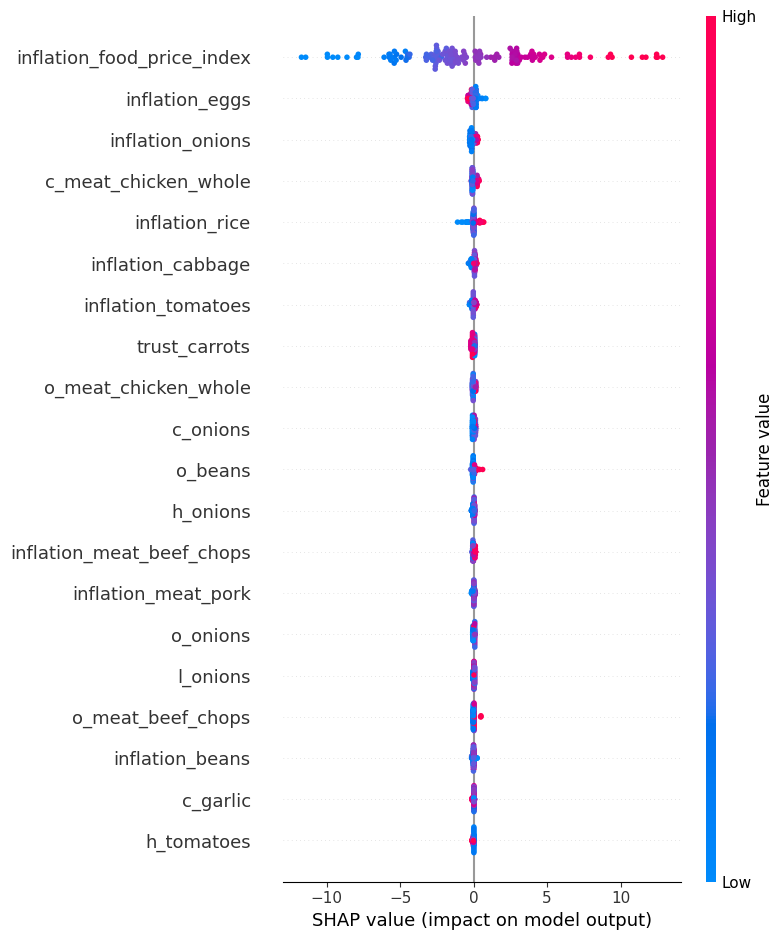

In [ ]:
# SHAP Summary Plot
shap.summary_plot(shap_values, X_train)

It can be seen that the food price index appears high on the y-axis, which indicates that this feature plays a crucial role in predicting the inflation rate.

At the same time, the plot reveals how different values of each feature influence the inflation rate predictions. It shows that the food price index has a wide spread along the x-axis, indicating that this feature has a substantial and variable effect on the predicted inflation rate. In contrast, the points for egg inflation and onion inflation are not as widely spread, suggesting that these features have a less variable impact on the predictions.

To gain a deeper understanding of the importance of each feature, we will use the SHAP dependence plot. This plot provides additional insights into how each feature affects the model’s predictions and illustrates the interaction between features, helping us to better comprehend their individual and combined impacts on the predicted inflation rate.

In [ ]:
# Let's have a look on the top features and their dependence plots
top_features = ['inflation_food_price_index', 'inflation_eggs', 'inflation_onions']
feature_list = ['c_meat_chicken_whole', 'inflation_rice', 'inflation_cabbage']

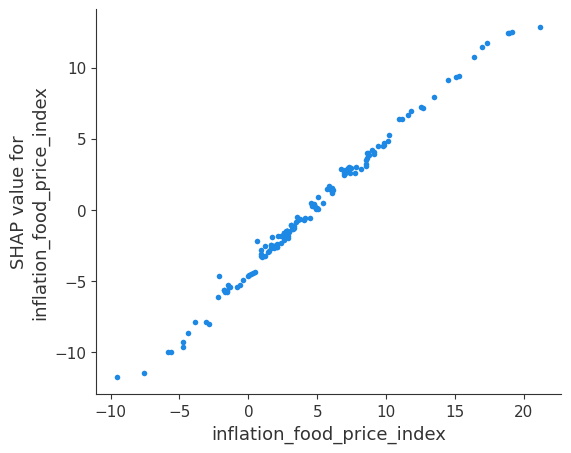

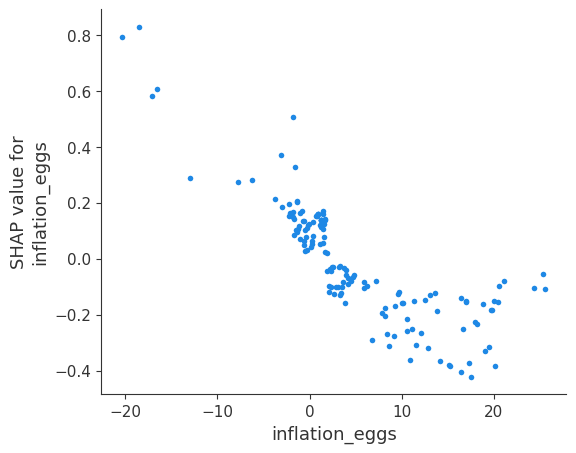

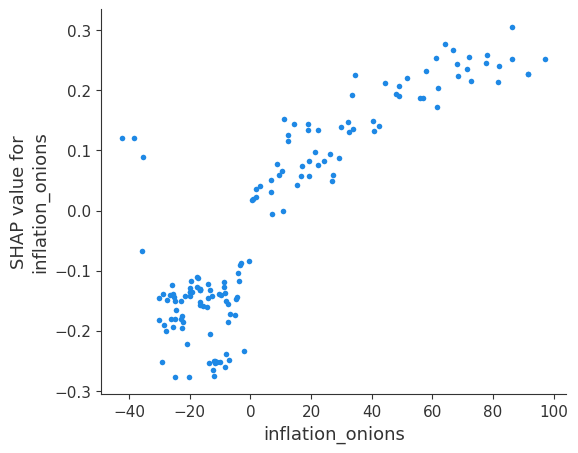

In [ ]:
for feature in top_features:
    shap.dependence_plot(feature, shap_values, X_train, interaction_index=None)

Based on the SHAP dependence plots, the model indicates that the inflation rate tends to increase when:

* The food price index is greater than 5.
* Egg inflation is less than 0.
* Onion inflation is greater than 0.

On the other hand, the model indicates that the inflation rate tends to decrease when:

* The food price index is less than 5.
* Egg inflation is greater than 0.
* Onion inflation is less than 0.

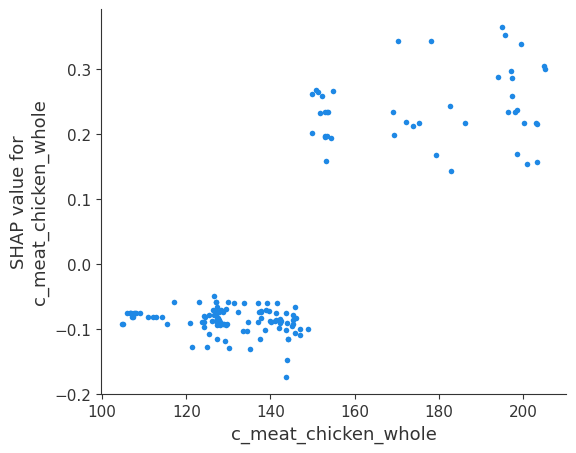

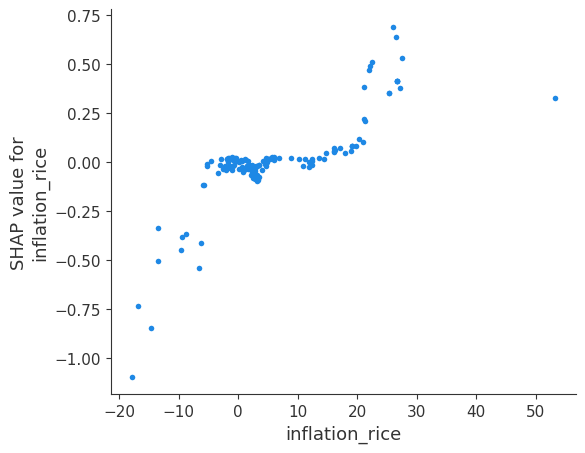

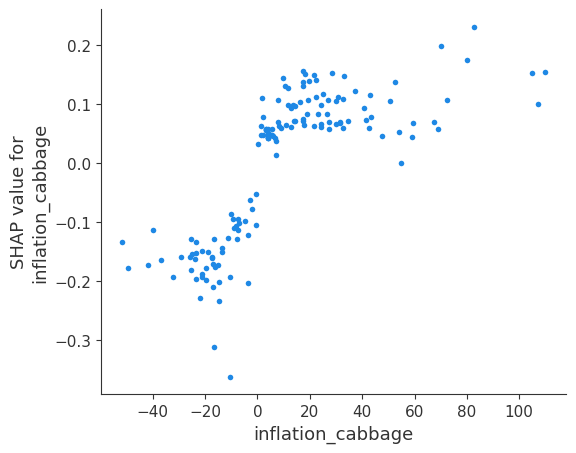

In [ ]:
for feature in feature_list:
    shap.dependence_plot(feature, shap_values, X_train, interaction_index=None)

Looking at the features, which are less important, we can say that the inflation rate is likely to increase if:

* The closing price of chicken meat is greater than 150.
* The inflation prices of rice and cabbage have positive value.

# Section 6: Conclusion And Recommendation

## Conclusion

During the model development phase, four different models were evaluated which are Random Forest Regressor, Support Vector Machine Regressor, XGBoost Regressor, and MLP Regressor (Neural Network). Each model was initially trained on the dataset to establish baseline performance metrics. Feature selection methods were applied tailored to each model: the Random Forest Regressor and XGBoost Regressor used embedded methods, the Support Vector Machine Regressor used Recursive Feature Elimination (RFE), and the MLP Regressor employed filter methods to identify significant features.

Grid Search was used to perform significant hyperparameter tuning to maximize the models' performance following feature selection. Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²) were the metrics used to evaluate the models.

With the lowest MSE and MAE values as well as an R-squared value that was very near to 1, the XGBoost Regressor was the model that performed the best overall. This indicates that, for this dataset, the XGBoost Regressor has the maximum prediction accuracy and dependability.

Feature importance analysis showed that the food price index, egg inflation, and onion inflation have significant influences on predicting the inflation rate. The SHAP summary plot confirmed that the food price index is the most significant feature, with a substantial and variable effect on the predicted inflation rate. In contrast, egg inflation and onion inflation have less variable impacts.

The SHAP dependence plots provided further insights into how each feature affects the model's predictions and how these effects vary with different feature values. Plots showed that when the food price index is more than 5, onion inflation is more than 0, and egg inflation is less than 0, the inflation rate tends to rise. On the other hand, when the food price index is less than 5, the inflation rate tends to go down; this is especially true for egg inflation, which goes up, and onion inflation, which goes down.

Additionally, features such as the closing price of chicken meat (if greater than 150) and positive inflation prices of rice and cabbage were identified as factors likely to increase the inflation rate, even though they were less important than the primary features.

## Recommendation

Here are some suggestions our group have based on feature importance studies and the outcomes of several models:

### Focus on Key Features

* Policies and strategies should focus on monitoring and controlling the food price index, egg inflation, and onion inflation, as these have the most significant impact on predicting inflation rates.
* Consider interventions to stabilize these key prices to manage inflation effectively.

### Monitor Additional Influential Features

* Keep an eye on the closing price of chicken meat, especially if it exceeds 150, as well as the inflation prices of rice and cabbage. Although these features are less important, they still contribute to inflation rate predictions and should be monitored.

### Use SHAP Dependence Plots for Additional Features to Gain Deeper Insights

* Utilize SHAP dependence plots for additional features to gain a more comprehensive understanding and make more informed recommendations for inflation predictions.
* This analysis can help design targeted measures to control inflation based on specific conditions.

### Regularly Update Models and Feature Analysis

* Continuously update the models and feature importance analysis as new data becomes available.
* This will ensure that the predictions remain accurate and relevant to current economic conditions.

### Implement Data-Driven Policies

* Implementing data-driven policies can earn the trust of the general public
* Effectively control the inflation rate, potentially preventing it from rising rapidly.